## Typical Sets and the Curse of Dimensionality
### _Aravind S_
### 24 Aug 2017
### Content of this notebook is  wholly derived from the original R notebook by Bob Carpenter (http://mc-stan.org/users/documentation/case-studies/curse-dims.html). Only the code has been translated from R to Python

### Abstract
This case study illustrates the so-called “curse of dimensionality,” starting from scratch and using simple examples based on simulation. For example, generating points uniformly at random in a unit hypercube, it is easy to see how the average distance between random points increases with dimensionality. Similarly, such points tend to increasingly fall outside the hypersphere inscribed within the unit hypercube, showing that in higher dimensions, almost all of the volume is in the corners of the hypercube.

Similarly, generating standard normal variates (zero mean, unit standard deviation) leads to draws that concentrate in a thin shell of increasing distance from the mean as dimensionality increases. The squared distance of a standard normal draw from the mode follows a standard chi-square distribution with degrees of freedom equal to the dimensionality. This allows the the precise bounds of the thin shell to be calculated using tail statistics, showing just how unlikely it is to get near the mode with a random draw from a standard multivariate normal.

These properties of the standard normal distribution provides a segue into discussing the important information-theoretic concept of the typical set for a probability distribution, which is roughly defined as the central log density band into which almost all random draws from that distribution will fall. The rather surprising result is that for a normal distribution in high dimensions, the typical set does not include the volume around the mode. The density is highest around the mode, but the volume is low, and the probability mass is determined as the product of the density and the volume (or more precisely, the integral of the density over the volume).

The standard normal log density is just negative squared Euclidean distance, which provides a straightforward demonstration of why the maximum likelihood estimate for a normal regression is identical to the least squares solution.

## 1. Euclidean Length and Distance

### Euclidean Length

Consider a vector $y=(y_1,…,y_N)$ with $N$ elements (we call such vectors $N$-vectors). The Euclidean length of a vector $y$ is written as $||y|| $, and defined by generalizing the Pythagorean theorem,

$$ \vert\vert{y}\vert\vert = \sqrt{y_1^2 + y_2^2 + ..... y_n^2} $$

In words, the length of a vector is the square root of the sum of the squares of its elements.

If we take $ y=(y_1,....y_N)$ to be a row vector, then we see that the dot product of a vector with itself is its squared length, so that
$$\vert\vert{y}\vert\vert = \sqrt{yy^T} $$

#### Calculating Vector Length in R

The following function computes vector length in R.

In [1]:
from __future__ import print_function, division
import numpy as np

def euclidean_length(x): return np.linalg.norm(x)

Using Python numpy, we can quickly compute the norm of a vector using the handy np.linalg.norm function. To test the function on a simple case, we can verify the first example of the Pythagorean theorem everyone learns in school, namely ||(3,4)||=5

In [2]:
euclidean_length(np.array([3, 4]))

5.0

### Euclidean Distance

The Euclidean distance between two NN-vectors, $ x=(x_1,…,x_N) $  and $ y=(y_1,…,y_N) $ , written $ d(x,y) $ is the Euclidean length of the vector $ x−y $ connecting them,

$$ d(x,y) = \sqrt{(x_1 - y_1)^2 +.....(X_N - y_N)^2} $$

In [3]:
x = np.array([3, 4])
y = np.array([2, 3])

euclidean_distance = euclidean_length(x-y)

In [4]:
euclidean_distance

1.4142135623730951

We can use the euclidean length function defined above to compute euclidean distance between tow vectors or use one of the handy functions in scipy.spatial.distance 

In [5]:
from scipy.spatial.distance import euclidean

In [6]:
euclidean(x,y)

1.4142135623730951

## 2. All of the Volume is in the Corners

Suppose we have a square and inscribe a circle in it, or that we have a cube and a sphere inscribed in it. When we extend this construction to higher dimensions, we get hyperspheres inscribed in hypercubes. This section illustrates the curious fact that as the dimensionality grows, most of the points in the hypercube lie outside the inscribed hypersphere.

Suppose we have an $N$-dimensional hypercube, with unit-length sides centered around the origin $0=(0,…,0)$. The hypercube will have $2^N$ corners at the points $ (\pm{\frac{1}{2}}...\pm{\frac{1}{2}})$. Because its sides are length 1, it will have also have unit volume, because 1^N=1.

If $ N=1 $, the hypercube is a line from $-\frac{1}{2} $ to $ +\frac{1}{2} $ of unit length (i.e., length 1). If $ N=2 $, the hypercube is a square of unit area with opposite corners at $ (-\frac{1}{2} , -\frac{1}{2}) $ and $ (+\frac{1}{2} , +\frac{1}{2})$. With $ N=3 $, we have a cube of unit volume, with opposite corners at  $ (-\frac{1}{2} , -\frac{1}{2}, -\frac{1}{2}) $ and $ (+\frac{1}{2} , +\frac{1}{2}, +\frac{1}{2})$, and unit volume. And so on up the dimensions.

Now consider the biggest hypersphere you can inscribe in the hypercube. It will be centered at the origin and have a radius of $ \frac{1}{2}$ so that it extends to the sides of the hypercube. A point $y$ is within this hypersphere if the distance to the origin is less than the radius, or in symbols, if $\vert\vert y \vert\vert < \frac{1}{2}$. Topologically speaking, we have defined what is known as an open ball, i.e., the set of points within a hypersphere excluding the limit points at distance exactly $\frac{1}{2}$ (we could’ve worked with closed balls which include the limit points making up the surface of the ball because this surface (a hypersphere) has zero volume).

In one dimension, the hypersphere is just the line from $-\frac{1}{2} $ to $ +\frac{1}{2} $ and contains the entire hypercube. In two dimensions, the hypersphere is a circle of radius $\frac{1}{2}$ centered at the origin and extending to the center of all four sides. In three dimensions, it’s a sphere that just fits in the cube, extending to the middle of all six sides.

### The Monte Carlo Method for Integration

We know the volume of the unit hypercube is one, but what is the volume of the ball in the inscribed hypersphere? You may have learned how to define an integral to calculate the answer for a ball of radius $r$ in two dimensions as $\pi r^2$, and may even recall that in three dimensions it’s $ \frac{4}{3}\pi r^3$. But what about higher dimensions?
<div style="width:3in; float:right; padding: 1em; border: 2">
<img src="https://upload.wikimedia.org/wikipedia/commons/8/8c/Monte_Carlo_Casino.jpg"></img> <span align="right"><em><small>Monte Carlo Casino. From Wikipedia, with license CC BY 2.5.</small></em> </div>

We could evaluate harder and harder multiple integrals, but we’ll instead use the need to solve these integrals as an opportunity to introduce the fundamental machinery of using sampling to calculate integrals. Such methods are called “Monte Carlo methods” because they involve random quantities and there is a famous casino in Monte Carlo. They are at the very heart of modern statistical computing (Bayesian and otherwise).



Monte Carlo integration allows us to calculate the value of a definite integral by averaging draws from a random number generator. (Technically, the random number generators we have on computers, like used in Python, are pseudorandom number generators in the sense that they’re underlyingingly deterministic; for the sake of argument, we assume they are random enough for our purposes in much the way we assume the functions we’re dealing with are smooth enough).

To use Monte Carlo methods to calculate the volume within a hypersphere inscribed in a hypercube, we need only generate draws at random in the hypercube and count the number of draws that fall in the hypersphere—our answer is the the proportion of draws that fall in the hypersphere. That’s because we deliberately constructed a hypercube of unit volume; in general, we need to multiply by the volume of the set over which we are generating uniform random draws.

As the number of draws increases, the estimated volume converges to the true volume. Because the draws are i.i.d., it follows from the central limit theorem that the error goes down at a rate of $ O(1/\sqrt(n))$. That means each additional decimal place of accuracy requires multiplying the sample size by one hundred. We can get rough answers with Monte Carlo methods, but many decimal places of accuracy requires a prohibitive number of simulation draws.

We can draw the points at random from the hypercube by drawing each component independently according to

$$ y_n \sim Uniform(- \frac{1}{2} , \frac{1}{2})$$

Then we count the proportion of draws that lie within the hypersphere. Recall that a point yy lies in the hypersphere if $ \vert\vert y \vert\vert < \frac{1}{2} $

### Using Monte Carlo methods to compute $\pi$

We’ll first look at the case where $N=2$ , just to make sure we get the right answer. We know the area inside the inscribed circle is $\pi r^2$ , so with $r=\frac{1}{2}$, that’s $\frac{\pi}{4}$. Let’s see if we get the right result.

In [7]:
N = 2
M = int(1e+6)
y = np.random.uniform(low=-0.5, high=0.5,size=(M,N))
p = np.sum(np.sqrt(y[:,0]**2 + y[:,1]**2) < 0.5)/M
print(4*p)

3.14156


Now, let’s generalize and calculate the volume of the hypersphere inscribed in the unit hypercube (which has unit volume by construction) for increasing dimensions.

In [8]:
from scipy.spatial.distance import cdist
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,10]
plt.style.use('seaborn-darkgrid')

/home/aravind/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [9]:
N_MAX = 10
M = int(1e+5)
dims = np.zeros(N_MAX, dtype=np.int32)
volume = np.zeros(N_MAX)
for N in range(1,N_MAX+1):
    y = np.random.uniform(low=-0.5, high=0.5,size=(M,N))
    # cdist computes distance between 2  matrices y-> (M,N) and [[0..0]]
    dist = cdist(y,np.expand_dims(np.zeros(N),0),metric='euclidean')
    p = np.sum(dist < 0.5)/M
    dims[N-1] = N
    volume[N-1] = p
df=pd.DataFrame(data={'dims': dims,'volume': volume})
print(df)

   dims   volume
0     1  1.00000
1     2  0.78633
2     3  0.52468
3     4  0.30967
4     5  0.16513
5     6  0.08162
6     7  0.03713
7     8  0.01632
8     9  0.00594
9    10  0.00211


Although we actually calculate the probability that a point drawn at random is inside the hyperphere inscribed in the unit hypercube, this quantity gives the volume inside the inscribed hypersphere.

Here’s the result as a plot.

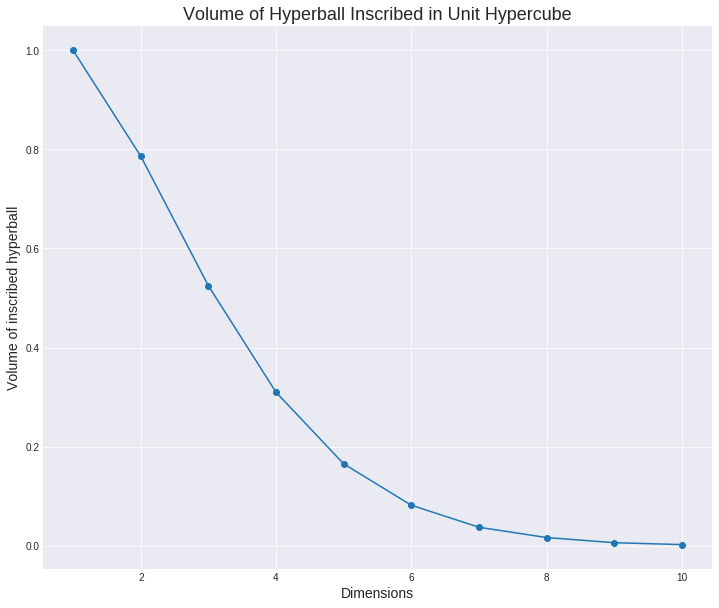

In [10]:
plt.plot(df.dims, df.volume,'o-')
plt.title('Volume of Hyperball Inscribed in Unit Hypercube',size=18)
plt.xlabel('Dimensions',size=14)
plt.ylabel('Volume of inscribed hyperball',size=14)

### All points are far away from each other

Another way of looking at this is that in higher dimensions, the points on average become further and further away from the center of the hypercube. They also become further and further away from each other (see the exercises). The volume of the hypersphere is the proportion of points in the hypercube that are within distance $\frac{1}{2}$ from the center of the hypercube; with inreasing dimension, vanishingly few points are within distance $\frac{1}{2}$ of the center of the hypercube.

As Bernhard Schölkopf said on Twitter, “a high-dimensional space is a lonely place.” What he meant by this is that not only are the points increasingly far from the mean on average, they are also increasingly far from each other. As Michael Betancourt noted in a comment on the pull request for this case study, “Take two points that are translated from each other by 1 unit in each direction — the distance between them grows as $\sqrt{N}$so as the dimension grows the points appear further from each other, with more and more volume filling up the space between them.”

## 3. Typical Sets

Roughly speaking, the typical set is where draws from a given distribution tend to lie. That is, it covers most of the mass of the distribution. This particular choice of volume not only covers most of the mass of a distribution, its members reflect the properties of draws from that distribution. What we will see in this section is that the typical set is usually nowhere near the mode of the distribution, even for a multivariate normal (where the mode is the same as the mean).

### A Discrete Example of Typicality

Typicality is easiest to illustrate with a binomial example. Consider a binary trial with an eighty percent chance of success (i.e., draws from a $ Bernoulli(0.80)$ distribution). Now consider repeating such a trial one hundred times, drawing $ y_1,…,y_{100}$ independently according to

$$ y_n \sim Bernoulli(0.8) $$


Two questions frame the discussion:

1. What is the most likely value for $ y_1,…,y_{100}$ ?

2. How many $y_n$ do you expect to be 1?

Let’s answer the second question first. If you have an 80% chance of success and make 100 attemps, the expected number of successes is just 80 (in general, it’s the probability of success times the number of attempts).

Then why is the most likely outcome 100 straight successes? The probability of 100 straight successes is $0.8^{100}$ or about $2\times10^{- 10}$.

In contrast, the probability of any given sequence with 80 successes is only $0.8^{80}0.2^{20}$, or about $2\times10^{- 22}$. The chance of 100 straight successes is a whopping $10^{12}$ times more probable than any specific sequence with 80 successes and 20 failures!

On the other hand, there are a lot of sequences with 80 successes and 20 failures—a total of ${100}\choose{80}$ of them to be exact (around $10^{20}$). So even though any given sequence of 80 success and 20 failures is relatively improbable, there are so many such sequences that their overall mass is higher than that of the unique sequence with 100 success, because $10^{20}\times2\times10^{- 22} $ is a lot bigger than $1\times2\times10^{- 10} $. Same goes for sequences with 81 successes; each such sequence is more probable than any sequence with 80 successes, but ${100}\choose{81}$ is smaller than ${100}\choose{80}$.

The binomial distribution is the distribution of counts, so that if $y_1,....y_N$ is such that each $y_n \sim Bernoulli(\theta)$, then

$$ (y_1 + ... +y_N) \sim Binomial(N,\theta) $$.


The binomial aggregates the multiple trials by multiplying through by the possible ways in which $y$ successes can arise in $N$ trials, namely

$$ Binomial(y \vert N, \theta) = {N \choose y} \theta^{y}(1-\theta)^{(N-y)} $$,

where the binomial coefficient that normalizes the distribution is defined as the number of binary sequences of length NN that contain exactly $y$ elements equal to 1,

$$ {N \choose y} = \frac{N!}{y!(N-y)!} $$

In words, $ Binomial(y \vert N, \theta)$ is the probability of $y$ successes in $N$ independent Bernoulli trials if each trial has a chance of success $\theta$.

To make sure we’re right in expecting around 80 succeses, we can simulate a million binomial outcomes from 100 trials with an 80% chance of success as

In [11]:
import scipy.stats as stats

In [12]:
z = stats.binom(100,0.8).rvs(int(1e6))
df_z = pd.Series(z)

with a summary

In [13]:
df_z.describe()

count    1000000.000000
mean          79.999140
std            4.005678
min           57.000000
25%           77.000000
50%           80.000000
75%           83.000000
max           97.000000
dtype: float64

and 99% interval

In [14]:
df_z.describe(percentiles=[ 0.005,0.995])[['0.5%','99.5%']]

0.5%     69.0
99.5%    90.0
dtype: float64

The most probable outcome as a sequence of Bernoulli trials, namely $(1,1,…,1)$, has a very improbable number of successes, namely $N$. A much more typical number of successes is 80. In fact, 100 isn’t even in the 99% interval of 100 trials with an 80% success rate. We can see that analytically using the quantile (inverse cumulative distribution function). Suppose we have a random variable $Y$ with mass or density function $p_Y(y)$. Then the cumulative distribution function (CDF) is defined by

$$ F_Y = Pr[Y \leq u].$$

For discrete probability (mass) functions, this works out to

$$ F_Y(u) = \sum_{y=-\infty}^{u} p_Y(y)$$

and for continuous probability (density) functions,

$$ F_Y(u) = \int_{-\infty}^{u} p_Y(y)dy .$$

What we are going to need is the inverse CDF, $F_Y^{-1}$, or quantile function, which maps a quantile $ \alpha \in (0,1)$ to the value $y$ such that $ Pr[Y \leq u] = \alpha $(this needs to be rounded in the discrete case to deal with the the fact that the inverse CDF is only technically defined for a countable number of quantiles).

Luckily, this is all built into Python, and we can calculate the quantiles that bound the central 99.9999% interval,

In [15]:
stats.binom(100,0.8).ppf((0.0000005, 0.9999995))

array([ 59.,  97.])

This tells us that 99.9999% of the draws (i.e, 999,999 out of 1,000,000 draws) from 𝖡𝗂𝗇𝗈𝗆𝗂𝖺𝗅(100,0.8) lie in the range (59,97). This demonstrates just how atypical the most probable sequences are.

We next reproduce a graphical illustration from David J. C. MacKay’s Information Theory, Inference, and Learning Algorithms (Cambridge, 2003, section 4.4) of how the typical set of the binomial arises as a product of

1. the Bernoulli trial probability of a sequence with a given number of successes, and

2. the number of sequences with that many successes.

Suppose we have a binary sequence of $N$ elements, $z=z_1,…,z_N$, with $ z_n \in {0,1} $ and let

$$ y = \sum_{n=1}^{N} z_n $$

be the total number of successes. The repeated Bernoulli trial probability of $z$ with a chance of success $ \theta \in [0,1] $ is given by the probability mass function

$$ p(z | \theta) = \prod_{n=1}^{N} Bernoulli(z_n|\theta) = \theta^{y}(1-\theta)^{(N-y)}$$

The number of ways in which a binary sequence with a total of yy successes out of NN trials can arise is the total number of ways a subset of yy elements may be chosen out of a set of NN elements, which is given by the binomial coefficient,

$$ {N \choose y} = \frac{N!}{y!(N-y)!} $$

The following plots show how the binomial probability mass function arises as a product of the binomial coefficient and the probability of a single sequence with a given number of successess. The left column contains plots on the linear scale and the right column plots on the log scale. The top plots are of the binomial coefficient, ${N \choose y}$. Below that is the plot the probability of a single sequence with yy successes, namely $\theta^{y}(1-\theta)^{(N-y)}$. Below both of these plots is their product, the binomial probability mass function 𝖡𝗂𝗇𝗈𝗆𝗂𝖺𝗅(y∣N,θ). There are three sequences of plots, for N=25, N=100, and N=400.

Just to get a sense of scale, there are $2^{25}$ (order $10^7$) binary sequences of length 25, $2^{100}$ (order $10^{30}$) binary sequences of length 100, and $2^{400}$ (order $10^{120}$) binary sequences of length 400.


In [16]:
def choose_df(Ys, theta=0.2):
    N = np.max(Ys)
    Ns = np.zeros_like(Ys)
    Ns.fill(N)
    Cs = scipy.misc.comb(N, Ys)
    Ls = theta**Ys * (1 - theta)**(N-Ys)
    Ps = Cs*Ls
    return pd.DataFrame({'y':Ys, 'N': Ns, 'combos': Cs, 'L':Ls, 'P':Ps})

def plot_all(df):
    fig,axes= plt.subplots(3,2)
    df[['combos','L','P']].plot(subplots=True,ax=axes[:,0],style='.-',alpha=0.5)
    df[['combos','L','P']].plot(subplots=True,logy=True, ax=axes[:,1], style='.-')
    for ax in axes.ravel():
        ax.set_xlabel("y")
        ax.set_xlim(-1,len(df))
    axes[0,0].set_ylabel(r"N choose y")
    axes[1,0].set_ylabel(r"$\theta^{y}(1-\theta)^{(N-y)}$")
    axes[2,0].set_ylabel(r"$binom(y|N,\theta)}$")
    axes[0,1].set_ylabel(r"log(N choose y)")
    axes[1,1].set_ylabel(r"$log \theta^{y}(1-\theta)^{(N-y)}$")
    axes[2,1].set_ylabel(r"$log binom(y|N,\theta)}$")
    plt.show()

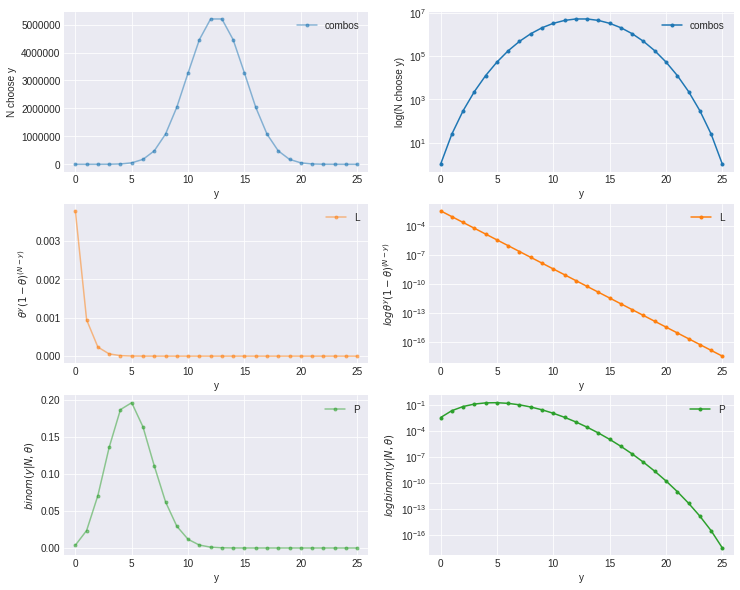

In [17]:
df25=choose_df(np.arange(0,26))
plot_all(df25)

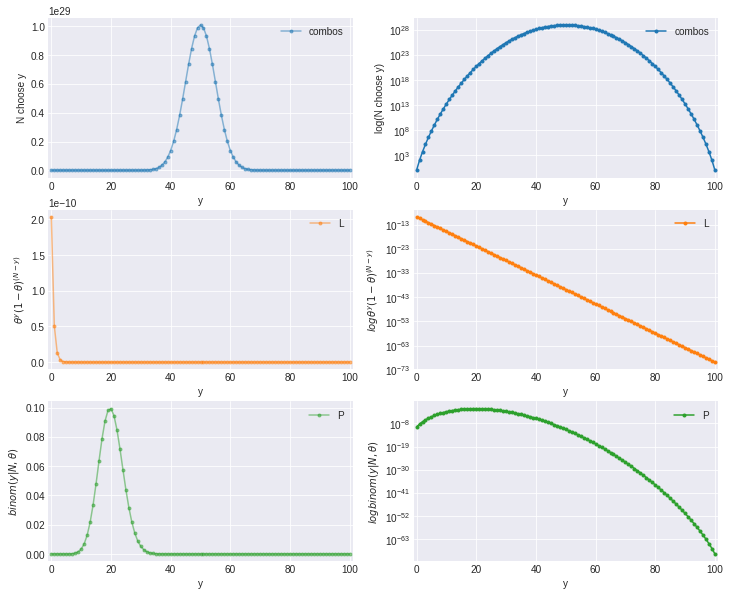

In [18]:
df100=choose_df(np.arange(0,101))
plot_all(df100)

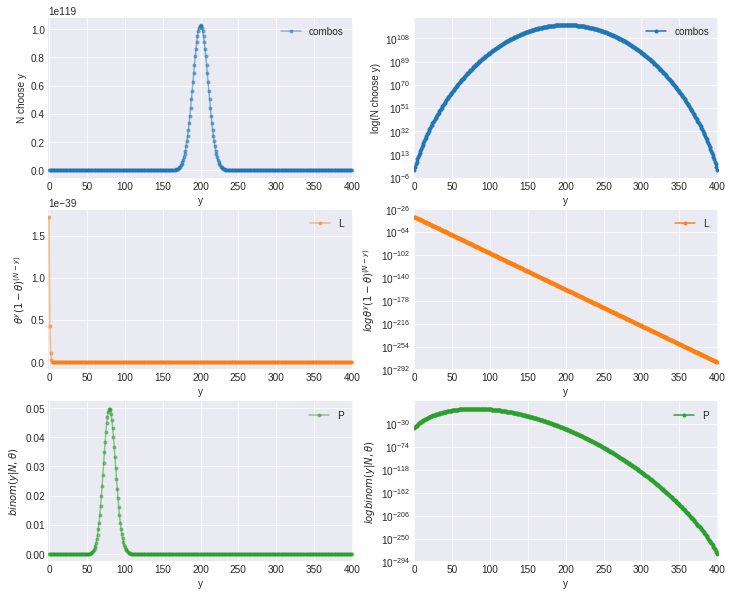

In [19]:
df400=choose_df(np.arange(0,401))
plot_all(df400)

Although it appears that way, the points are not getting heavier, there are just more of them in each subsequent plot.

### A continuous example of Typicality

All of the computations of interest in Bayesian statistics are formulated as posterior expectations. For example, Bayesian parameter estimates minimizing expected square error are expectations of the value of a parameter $\theta$ in the posterior (conditioned on data $y$),

$$ \hat\theta = \mathbb{E}[\theta | y] = \int_{\Theta}\theta p(\theta | y) d\theta$$,

where we integrate over the legal values of $\theta \in \Theta$

Posterior event probabilities are expectations of the indicator function $I[\theta \in E]$ that indicates whether a parameter value $\theta$ is in the event,

$$ Pr[E | y] = \mathbb{E}[I[\theta \in E ]| y] = \int_{\Theta}I[\theta \in E] p(\theta | y) d\theta $$


Rather than integrating over the support $\theta$ of $\Theta$ in the posterior, it suffices to integrate over the typical set (the typical set is not the only such set; see the exercises for a discussion of the highest probability set). That is, if $\Theta$ is the support for a density$p(\theta)$, then the typical set $T \subseteq \Theta$ has the property that for “well-behaved” functions,

$$ \mathbb{E}[f(\theta) | y] = \int_{\Theta}f(\theta) p(\theta | y) d\theta \approx \int_{T}f(\theta) p(\theta | y) d\theta $$

That is, we can restrict attention to the typical set when computing expectations. The fact that typical sets exist is why we are able to compute posterior expectations using Monte Carlo methods—the draws from the posterior distribution we make with Monte Carlo methods will almost all fall in the typical set and we know that will be sufficient.

We saw in the first plot in section 4 (draws are nowhere near the mode) that if we have $D$ i.i.d. draws from a standard normal, that the typical set was well bounded away from the posterior mode, which is at the origin. The next section shows that the distance from the mode reduces to a well-known distribution.

### Definition of the Typical Set

The formal definition of typicality is for sequences $x_1,....x_N $ of i.i.d. draws with probability function $p(x)$ (density function for continuous variables, mass function for discrete variables). Such a sequence is said to be “typical” if its average probability is near the (differential) entropy of the distribution. A sequence $(x_1....x_N)$ is in the typical set $A_{\epsilon}^{N}$for a distribution with probability function $p(x)$ if

$$ \lvert { \frac{1}{N} \sum_{n=1}^{N}logp(x_n)-H[X]} \rvert \leq \epsilon$$

where $H[X]$ is the discrete entropy if $X$ is discrete and the differential entropy if $X$ is continuous. It can be established that such a set covers most such sequences, in that
$$ Pr[(X_1,....X_N) \in A_{\epsilon}^{N}] > 1 - \epsilon$$

assuming the $X_n$ are independent and each has probability function $p(x)$.

## 4. The Normal Distribution

The normal log density for a variate $y \in \mathbb{R}$ with location $\mu \in \mathbb{R}$ and scale $\sigma \in \mathbb{R}^+$ is defined by

$$ \mathsf{Normal}(y \mid \mu, \sigma) = \frac{1}{\sqrt{2 \pi}}\frac{1}{\sigma} \exp \left( -\frac{1}{2} \left( \frac{y - \mu}{\sigma} \right)^2 \right). $$

For the standard normal, $\mathsf{Normal}(0, 1)$, many terms drop out, and we are left with

$$ \mathsf{Normal}(y \mid 0, 1) = \frac{1}{\sqrt{2 \pi}} \exp \left( -\frac{1}{2} \ y^2 \right). $$

Converting to the log scale, we have

$$ \log \mathsf{Normal}(y \mid 0, 1) \ = \ -\frac{1}{2} \ y^2 + \mathrm{constant} $$

where the constant does not depend on $y$. In this form, it's easy to see the relation between the standard normal and distance. For multiple i.i.d. standard normal draws $y = (y_1, \ldots, y_N)$, then 
$$ \log p(y)  = \sum_{n=1}^N -\frac{1}{2} y_n^2  =-\frac{1}{2} yy^{\top}  = \frac{1}{2} || y ||^2 $$
In words, the log density of a standard normal distribution is proportional to half the squared distance from the origin. This is why the maximum likelihood estimate is equal to the least squares estimate for normal distributions.

## 5. Vectors of Random Unit Normals

We are now going to generate a random vector $y = (y_1, \ldots, y_D) \in \mathbb{R}^D$ by generating each dimension independently as

$$ y_d \sim \mathsf{Normal}(0, 1). $$

The density over vectors is then defined by

$$ p(y)  = \prod_{d=1}^D p(y_d)  = \prod_{d=1}^D \mathsf{Normal}(y_d \mid 0, 1). $$

On the log scale, that's

$$ \log p(y)  = \sum_{d=1}^D -\frac{1}{2} , y_d^2 + \mathrm{const} = -\frac{1}{2} {|| y ||}^2 + \mathrm{const}.$$

Equivalently, we could generate the vector $y$ all at once from a multivariate normal with unit covariance matrix,

$$ y \sim \mathsf{MultiNormal}(\mathbf{0},\mathbf{I}), $$

where $\mathbf{0}$ is a $D$-vector of zero values, and $\mathbf{I}$ is the $D \times D$ unit covariance matrix with unit values on the diagonal and zero values off diagonal (i.e., unit scale and no correlation).



To generate a random vector $y$ in Python, we can use the np.random.randn() function, which generates univariate random draws from a normal distribution.

In [20]:
D = 10
u = np.random.randn(10)
print(u)

[-0.04096716 -1.35082194  1.08334384  0.80308549 -1.3615433  -0.2544608
  0.31720978 -1.31040512 -0.35133233  2.4171712 ]


It is equally straightforward to compute the Euclidean length of u given the function we defined above:

In [21]:
print(euclidean_length(u))

3.65341805759


What is the distribution of the lengths of vectors generated this way as a function of the dimensionality? We answer the question analytically in the next section, but for now, we’ll get a handle on what’s going on through simulation as the dimensionality $D$ grows. The following code draws from normal distributions of dimensionality 1 to 256, then plots them with 99% intervals

In [22]:
N = int(1e4)
dim = np.array([1, 2, 4, 5, 8, 11, 16, 22, 32, 45, 64, 90, 128, 181, 256])
log_sum_exp = lambda u : np.max(u) + np.log(np.sum(np.exp(u-np.max(u))))
D = len(dim)

lower = np.zeros(D);
middle = np.zeros(D);
upper = np.zeros(D);
lower_ll = np.zeros(D);
middle_ll = np.zeros(D);
upper_ll = np.zeros(D);

mean_ll = np.zeros(D);
max_ll = np.zeros(D);

for k in range(D):
    d = dim[k]
    y = np.zeros(N)
    for n in range(N):
        y[n] = euclidean_length(np.random.randn(d))
    
    lower[k] = np.percentile(y,.5)
    middle[k] = np.percentile(y,50)
    upper[k] = np.percentile(y,99.5)
    ll = np.zeros(N)
    for n in range(N):
        ll[n] = np.sum(stats.norm.logpdf(np.random.randn(d)))
    
    lower_ll[k] = np.percentile(ll,.5)
    middle_ll[k] = np.percentile(ll,50)
    upper_ll[k] = np.percentile(ll,99.5)
    
    mean_ll[k] = log_sum_exp(ll) - np.log(N)
    max_ll[k] = np.sum(stats.norm.logpdf(np.zeros(d)))

In [23]:
from collections import OrderedDict
df = pd.DataFrame(OrderedDict({'dim':dim, 'lb':lower, 'mid': middle, 'ub': upper,
                      'lb_ll' : lower_ll, 'mid_ll': middle_ll,
                      'ub_ll' : upper_ll, 'mean_ll' : mean_ll, 'max_ll' : max_ll}))

In [24]:
df

,dim,lb,mid,ub,lb_ll,mid_ll,ub_ll,mean_ll,max_ll
0,1,0.006618,0.676257,2.731542,-5.070500,-1.145166,-0.918959,-1.262745,-0.918939
1,2,0.107905,1.173501,3.270822,-7.136781,-2.532103,-1.842560,-2.535267,-1.837877
2,4,0.454040,1.824143,3.801949,-11.113101,-5.326899,-3.785171,-5.043589,-3.675754
3,5,0.629350,2.075866,4.105867,-12.834859,-6.785630,-4.811261,-6.324351,-4.594693
4,8,1.194197,2.709017,4.669746,-18.313018,-11.056964,-8.019325,-10.144568,-7.351508
5,11,1.590146,3.214823,5.136521,-23.654041,-15.288273,-11.379914,-13.924195,-10.108324
6,16,2.276279,3.923871,5.914404,-31.776311,-22.404094,-17.339220,-20.269823,-14.703017
7,22,2.918912,4.599726,6.571233,-41.626799,-30.878834,-24.607790,-27.857079,-20.216648
8,32,3.866251,5.595134,7.452209,-57.668499,-45.077463,-37.025508,-40.645151,-29.406033
9,45,4.946729,6.648373,8.616273,-78.229283,-63.454094,-53.388498,-56.866461,-41.352234


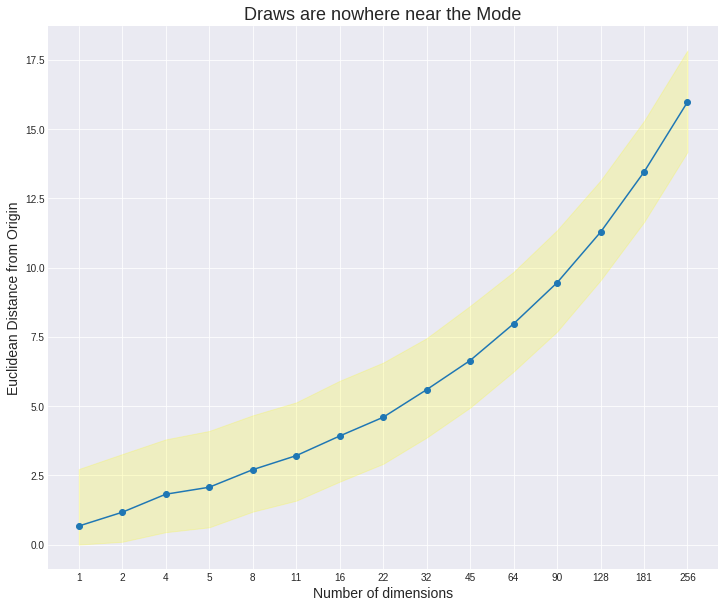

In [25]:
plt.plot(df.mid,'o-')
plt.fill_between(np.arange(len(df)),df.lb, df.ub,color='yellow', alpha=0.2)
plt.xticks(np.arange(len(df)), df.dim)
plt.xlabel('Number of dimensions',size=14)
plt.ylabel('Euclidean Distance from Origin',size=14)
plt.title('Draws are nowhere near the Mode', size=18)
plt.show()

Even in 16 dimensions, the 99% intervals are far away from zero, which is the mode (highest density point) of the 16-dimensional unit normal distribution.

### Concentration of Measure

Not only are the intervals moving away from the mode, they are concentrating into a narrow band in higher dimensions. This result follows here from the central limit theorem in this example and in more generality from concentration of measure (Terry Tao blogged a nice introduction).

How does the log density of random draws compare to the log density at the mode (i.e., the location at which density is maximized)? The following plot of the median log density and 99% intervals along with the density at the mode illustrates.

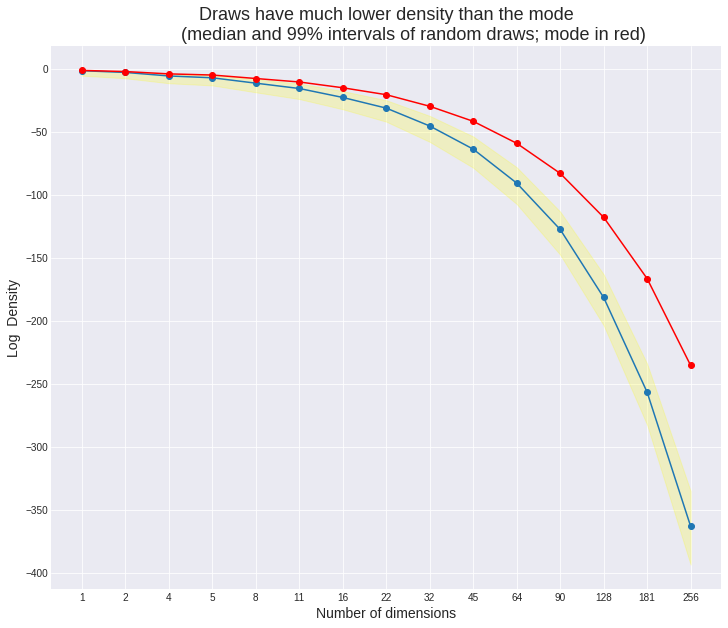

In [26]:
plt.plot(df.mid_ll,'o-')
plt.plot(df.max_ll,'ro-')
plt.fill_between(np.arange(len(df)),df.lb_ll, df.ub_ll,color='yellow', alpha=0.2)
plt.xticks(np.arange(len(df)), df.dim)
plt.xlabel('Number of dimensions',size=14)
plt.ylabel('Log  Density',size=14)
plt.title('Draws have much lower density than the mode\n \
          (median and 99% intervals of random draws; mode in red)', size=18)
plt.show()

### No individual is average

Somewhat counterintuitively, although easy to see in retrospect given the above graphs, the average member of a population is an outlier. How could an item with every feature being average be unusual? Precisely because it is unusual to have so many features that close to average.

In comments on an earlier draft, Michael Betancourt mentioned that physicists like to use an average of a population as a representative, calling such a representative an “Asimov data set” (the name derives from Isaac Asimov’s 1955 short story Franchise, in which a single elector is chosen to represent a population). Because of the atypicality of the average member of the population, this technique is ripe for misuse. As we saw above, the average member of a population might be located at the mode, whereas the average distance of a population member to the mode is much greater.

## 6. Squared Distance of Normal Draws is Chi-Square

Suppose $y = (y_1, \ldots, y_D) \in \mathbb{R}^D$ and that for each $d \in 1{:}D$,

$$ y_d \sim \mathsf{Normal}(0, 1), $$

is drawn independently. The distribution of the sum of the squared elements of $y$ is well known to have a chi-square distribution,

$$ (y_1^2 + \cdots + y_D^2) \sim \mathsf{ChiSquare}(D). $$

In other words, the squared length of a unit normal draw has a chi-square distribution,

$$ {|| y ||}^2 \sim \mathsf{ChiSquare}(D). $$

This means we could have drawn the plot out analytically rather than using Monte Carlo methods by using the inverse cumulative distribution function for the chi-square distibution (see the exercises).

## 7. Maximum Likelihood and Least Squares

Gauss recognized the intimate relation between (squared Euclidean) distance and the normal distribution. The connection led him to develop the maximum likelihood principle and show that the maximum likelihood estimate of the mean of a normal distribution was the average, and that such an estimate also minimized the sum of square distances to the data points.

Suppose we observe $y = (y_1, \ldots, y_N) \in \mathbb{R}^N$ and we assume they come from a normal distribution with unit scale $\sigma = 1$ and unknown location $\mu$. Then the log density is

$$ \log p(y \mid \mu, 1) \propto \sum_{n=1}^N \log \mathsf{Normal}(y_n \mid \mu, 1) \ \propto -\frac{1}{2} \sum_{n=1}^N \left( y_n - \mu \right)^2 \ \propto -\frac{1}{2} \sum_{n=1}^N \mathrm{d}(y_n, \mu)^2. $$

The maximum likelihood estimate for the location $\mu$ is just the value that maximizes the likelihood function,

$$ \mu^* \ = 
\mathrm{arg  max}_{\mu} \ p(y \mid \mu) \ = 
\mathrm{arg max}_{\mu} \ \log p(y \mid \mu) \ = 
\mathrm{arg  max}_{\mu} - \frac{1}{2} , \sum_{n=1}^N \mathrm{d}(y_n, \mu)^2 \ = 
\mathrm{arg  min}_{\mu} \sum_{n=1}^N \mathrm{d}(y_n, \mu)^2. $$

The last step drops the negative constant multiplier, thus converting maximization to minimization and showing that the estimate that maximizes the likelihood is also the estimate that minimizes the sum of the square distances from the observations to the estimate of $\mu$.

The estimate that minimizes squares is just the average of the observations,

$$ \mu^* \ = 
\frac{1}{N} \sum_{n=1}^N y_n. $$

The Gauss-Markov theorem further establishes that the mean has the lowest variance among unbiased estimators (it also generalizes the result to linear regressions).

## Acknowledgements

Thanks to Bob Carpenter for the original content and code. Thanks to Michael Betancourt for comments on an earlier draft of this paper and to the reader's of Andrew Gelman's blog for a long series of comments on typical sets in response to my original post on ensemble methods.

## References

Cover and Thomas (2006) is the standard reference for information theory and provides full definitions of entropy, differential entropy, highest probability sets, typical sets, and the connection of the typical set to the asymptotic equipartition property (AEP). Robert and Casella (2005) cover a range of statistical applications of Monte Carlo methods; they also published a companion version with R code. MacKay (2003) provides a more computationally oriented introduction to both Monte Carlo methods and information theory, with straightforward implementations in MATLAB/Octave.

Cover, T. M., and Thomas, J. A. 2006. Elements of Information Theory. 2nd Edition. John Wiley & Sons.

Robert, C. P. and G. Casella. 2005. Monte Carlo Statistical Methods. Springer.

MacKay, David J. C. 2003. Information Theory, Inference and Learning Algorithms. Cambridge University Press.

## Exercises

1. Define an Python function for the Euclidean distance between two vectors. What happens if you use numpy's matrix multiplication, such as u @ v?

2. Given $y_n \in \mathbb{R}$ for $n \in 1{:}N$, the maximum likelihood estimate of $\mu$ for the model $$ p(y \mid \mu) = \prod_{n=1}^N \mathsf{Normal}(y_n \mid \mu, 1) $$ is just the average of the $y_n$ (i.e., $\mu^* = \bar{y}$, where $\bar{y}$ is standard notation for the average of $y$). Hint: show that the first derivative of the log likelihood with respect to $\mu$ is zero and the second derivative is negative.

3. For the model in the previous question, show that the maximum likelihood estimate for $\mu$ is the same no matter what $\sigma$ is. Use this fact to derive the maximum likelihood estimate for $\sigma$. How does the maximum likelihood estimate differ from the statistic known as the sample standard deviation, defined by $$ \mathrm{sd}(y) = \sqrt{\frac{1}{N - 1} \sum_{n=1}^N (y_n - \bar{y})^2}, $$ with $\bar{y} = \frac{1}{N} \sum_{n=1}^N y_n$ being the average of the $y_n$ values. For a fixed scale $\sigma = 1$, show that the maximum likelihood estimate for a normal mean parameter is equal to the average of the observed $y$.

4. Show that the Euclidean length of a vector $y$ is its distance to the origin, i.e., $$ || y || = \mathrm{d}(y, \mathbf{0}), $$ where $\mathbf{0} = (0, \ldots, 0)$ is the zero vector.

5. Repeat the computational distance calculations for the $\mathrm{L}_1$ norm, defined by $$ {|| y ||}_1 = | y_1 | + | y_2 | + \cdots + | y_D |. $$ and the taxicab distance, defined by $$ d_1(u, v) = {|| u - v ||}_1. $$ The taxicab distance (or Manhattan distance) is so-called because it may be thought of as a path in Euclidean distance that follows the axes, going from $(0,0)$ to $(3, 4)$ by way of $(3,0)$ or $(0, 4)$ (that is, along the streets and avenues).

6. Use random number generation and plotting to show what happens to the distance between two points generated uniformly at random in a unit hypercube as the number of dimensions increases.

7. Show how the double exponential distribution (aka Laplace distribution) plays the same role with respect to the $\mathrm{L}_1$ norm and taxicab distance as the normal distribution plays with respect to the $\mathrm{L}_2$ norm and Euclidean distance.

8. Repeat the computational distance calcuations for the $\mathrm{L}{\infty}$ norm and associated distance function, defined by $$ {||y||}{\infty} = \max \{ | y_1 |, ..., | y_D | \}. $$ If the elements of $y$ are independently drawn from a unit normal distribution, the $\mathrm{L}_{\infty}$ norm has the distribution of the $D$-th order statistic for the normal.

9. Recreate the curves in the first few plots using the inverse cumulative distribution function for the chi-square distribution.

10. Show that the log density for a multivariate distribution with unit covariance and mean vector $\mu$ is equal to half squared distance between $y$ and $\mu$ plus a constant. In symbols, $$ \log \mathsf{MultiNorm}(y \mid \mu, \mathbf{I}) = \frac{1}{2}  \mathrm{d}(y, \mu)^2 + \mathrm{constant}. $$

11. Show that the log density of a vector $y$ in a multivariate normal distribution with location $\mu$ and covariance matrix $\Sigma$ is half the distance between $y$ and $\mu$ in the Riemannian manifold for which the inverse covariance matrix $\Sigma^{-1}$ defines a metric using the standard quadratic form, $$ \mathrm{d}(y, \mu) = (y - \mu)  \Sigma^{-1}  (y - \mu)^{\top}. $$

12. The $\mathrm{L}_p$ norm is defined for a vector $y = (y_1, \ldots, y_N)$ and $p > 0$ by $$ ||y||_p = \left( \sum_{n=1}^N {|y_n|}^p \right)^\frac{1}{p} $$ Show that Euclidean distance is defined by the $\mathrm{L}_2$ norm and the taxicab distance by the $\mathrm{L}_1$ norm. What happens in the limits as $p \rightarrow 0$ and $p \rightarrow \infty$?

13. Use the qchisq function in R to generate the median and 99% (or more extreme) intervals for the distribution of lengths of vectors with dimensions drawn as independent unit normals. Use qbinom to do the same thing for binomial draws with an 80% chance of success to illustrate how atypical the all-success draw is.

14. The smallest set by volume that contains $1 - \epsilon$ of the probability mass is called the highest probability set. In a univariate, unimodal density, the highest probabilty set is the highest density interval (HDI). Show that the probability of a random draw falling in the difference between these sets (typical set and highest probability set) quickly converges to zero.

15. Use the central limit theorem to show why a chi-square distribution tends toward a normal distribution as the number of degrees of freedom grows.

#### Licenses

Python Code used in this notebook is Copyright(2017) Aravind S. Released under BSD-3 clause license

Original Code: Copyright (2017) Columbia University. Released under the BSD 3-clause license.

Original Text: Copyright (2017) Bob Carpenter. Released under the the CC BY-NC 4.0 license.

#### Platform



In [27]:
import sys
import matplotlib

In [28]:
# conda install numpy scipy matplotlib pandas seaborn
print('Tested on Python 2.7,3.6')
print("Numpy Version : ", np.__version__)
print("Scipy Version : ", scipy.__version__)
print("Pandas Version : ", pd.__version__)
print("Matplotlib Version: ", matplotlib.__version__)

Tested on Python 2.7,3.6
Numpy Version :  1.12.1
Scipy Version :  0.19.0
Pandas Version :  0.20.1
Matplotlib Version:  2.0.2
